In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df=pd.read_csv('drive/MyDrive/lab4/Eximbank.csv')
df
df1=df.reset_index()['Close']

In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,7838.982910,7980.226074,7838.982910,7909.604492,7909.604492,136913
1,2016-01-05,7838.982910,7980.226074,7838.982910,7909.604492,7909.604492,298308
2,2016-01-06,7768.361816,7980.226074,7768.361816,7909.604492,7909.604492,377236
3,2016-01-07,7838.982910,7909.604492,7768.361816,7838.982910,7838.982910,298832
4,2016-01-08,7768.361816,7768.361816,7697.740234,7697.740234,7697.740234,424686
...,...,...,...,...,...,...,...
2043,2024-03-14,18200.000000,18200.000000,17900.000000,17950.000000,17950.000000,14772700
2044,2024-03-15,17950.000000,18300.000000,17850.000000,17850.000000,17850.000000,30799500
2045,2024-03-18,17900.000000,18400.000000,17700.000000,18400.000000,18400.000000,30643400
2046,2024-03-19,18450.000000,19000.000000,18300.000000,18600.000000,18600.000000,42471300


In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [10]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(1332, 100)
(1332,)
(514, 100)
(514,)


In [13]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [14]:
kf = kf.em(X_train[0])

In [15]:
test_data.shape

(615, 1)

In [16]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [17]:
test_predicted.shape

(615, 1)

In [18]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [19]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [20]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 310.53883397804316
Testing MAPE: 0.7753303016401344
Testing MAE: 144.23432404718528


In [21]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

555

In [22]:
test_data[60:].shape

(555, 1)

In [23]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 [0.66129097]
 [0.67236448]
 [0.66378213]
 [0.65895639]
 [0.67261999]
 [0.67808454]
 [0.68189517]
 [0.68719854]
 [0.69197229]
 [0.68540134]
 [0.68326182]
 [0.72522292]
 [0.70740006]
 [0.7015969 ]
 [0.70783268]
 [0.70986306]
 [0.71255546]
 [0.70327551]
 [0.68705038]
 [0.67770483]
 [0.6645053 ]
 [0.6683328 ]
 [0.66653202]
 [0.66289872]
 [0.66577833]
 [0.66062201]
 [0.65995876]
 [0.66075846]
 [0.66000318]
 [0.66178858]
 [0.65627597]
 [0.64635577]
 [0.64109442]
 [0.63836566]
 [0.63849283]
 [0.6415812 ]
 [0.64563374]
 [0.65710986]
 [0.65576823]
 [0.65228437]
 [0.64708741]
 [0.64539526]
 [0.64078168]
 [0.63927949]
 [0.63777472]
 [0.63830042]
 [0.63847159]
 [0.63852732]
 [0.6365141 ]
 [0.63179597]
 [0.63432236]
 [0.63920764]
 [0.63876698]
 [0.63659213]
 [0.66229119]
 [0.66558052]
 [0.65751064]
 [0.65183605]
 [0.64897274]
 [0.64804044]
 [0.64875254]
 [0.65507838]
 [0.65612243]
 [0.65341536]
 [0.66167488]
 [0.70803757]
 [0.76883808]
 [0.764259 

In [24]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

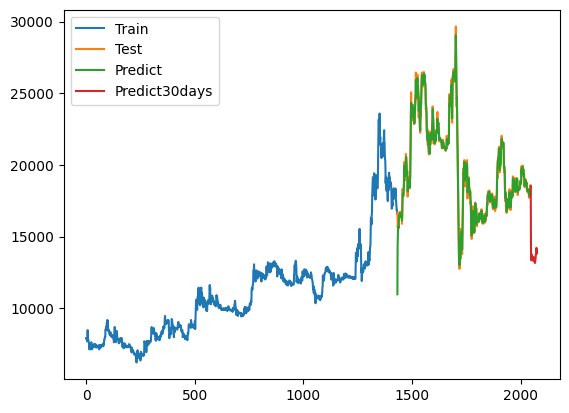

In [25]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

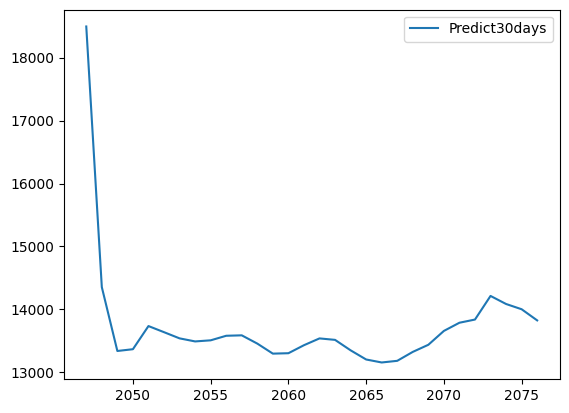

In [26]:
# 14.Vẽ hình
# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped))
plt.legend(['Predict30days'])
plt.show()